# TP2

### Membres de l'équipe

1. **Emil Surkhaev** - SURE89080008
2. **Keven Jude Anténor** - ANTK08129003
3. **Gabriel Silès Deschênes** - SILG09109901
4. **Juan Ruesga** - RUEJ31107808


### Code pour tester les Architechtures 

In [30]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import h5py
import os
import logging

# Configurer les avertissements de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('absl').setLevel(logging.ERROR)

# Charger le modèle
model = tf.keras.models.load_model('modele-B.h5')

# Charger les noms des classes depuis le fichier HDF5
with h5py.File('modele-B.h5', 'r') as f:
    class_names = [name.decode('utf-8') for name in f.attrs['class_names']]

# Dictionnaire de traduction de l'italien au français
translation_dict = {
    'Fursuit': 'Fursuit',
    'scoiattolo': 'écureuil',
    'ragno': 'araignée',
    'pecora': 'mouton',
    'mucca': 'vache',
    'gatto': 'chat',
    'gallina': 'poule',
    'farfalle': 'papillon',
    'elefante': 'éléphant',
    'cavallo': 'cheval',
    'cane': 'chien',
}

def traduire_au_francais(name):
    return translation_dict.get(name, name)  # Retourne le nom original s'il n'y a pas de traduction

def predire_image(img_path):
    img = image.load_img(img_path, target_size=(64, 64))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Faire des prédictions
    predictions = model.predict(img_array)
    predictions = predictions[0]
    
    # Décider si c'est un fursuit ou un animal
    class_idx = np.argmax(predictions)
    
    if class_names[class_idx] == 'Fursuit':
        print('Fursuit : oui')
        print('Fursuit : -')
    else:
        print('Fursuit : non')
        # Traduire le nom de l’espèce en français
        nom_francais = traduire_au_francais(class_names[class_idx])
        print("Espèce :", nom_francais)
        

# Exemple de prédiction
predire_image('Test/oveja2.jpeg')


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step
Fursuit : non
Espèce : mouton


### Réseau A

| Composant                | Description                                                             |
|--------------------------|-------------------------------------------------------------------------|
| **Taille de l'image**    | 64 x 64                                                                 |
| **Taille du batch**      | 1100                                                                    |
| **Époques d'entraînement** | 5                                                                     |

Found 26379 files belonging to 11 classes.
Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.1522 - loss: 2.3242 - val_accuracy: 0.2157 - val_loss: 2.3053
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2020 - loss: 2.2277 - val_accuracy: 0.2740 - val_loss: 2.1231
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 62s 3s/step - accuracy: 0.2661 - loss: 2.0860 - val_accuracy: 0.3360 - val_loss: 1.9834
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.3070 - loss: 1.9824 - val_accuracy: 0.3756 - val_loss: 1.8850
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.3326 - loss: 1.9106 - val_accuracy: 0.4079 - val_loss: 1.7909


35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


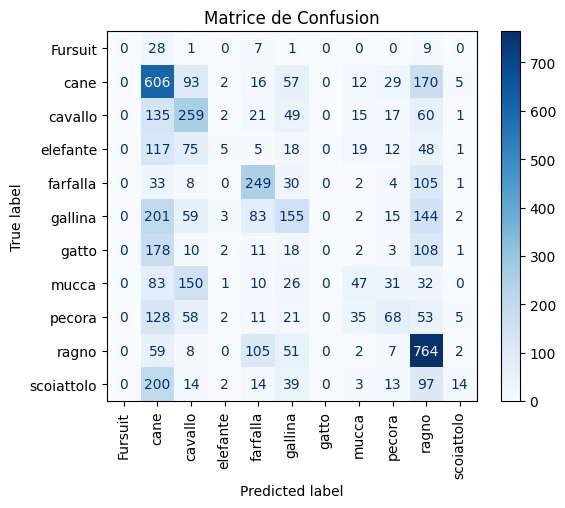

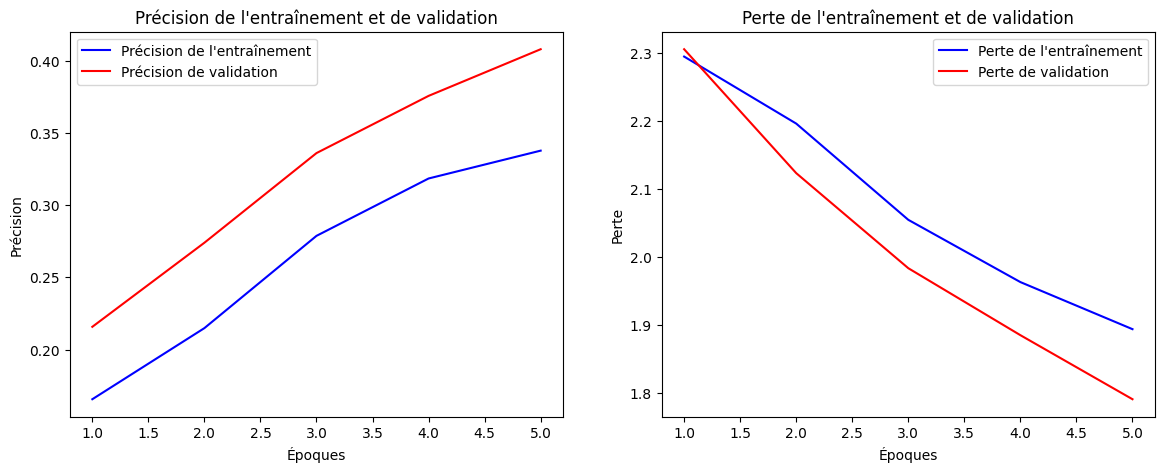

In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=1100,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

# Appliquer le prétraitement sur le dataset
dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle avec Dropout
inputs = tf.keras.Input(shape=(64, 64, 3))  # Définir la forme d'entrée

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)  # Dropout après la première couche de convolution

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)  # Dropout après la deuxième couche de convolution

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)  # Dropout après la troisième couche de convolution

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout avant la couche dense finale

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)  # Couche de sortie avec activation softmax

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)  # Créer le modèle

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=5
)

# Sauvegarder le modèle
model1.save('model-A.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('model-A.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Fonction pour obtenir les labels et prédictions
def get_labels_and_predictions(dataset, model):
    all_labels = []
    all_predictions = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_labels.append(labels.numpy())
        all_predictions.append(np.argmax(predictions, axis=-1))
    return np.concatenate(all_labels), np.concatenate(all_predictions)

# Évaluation du modèle
val_labels, val_predictions = get_labels_and_predictions(val_dataset, model1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model B

| Composant                | Description                                                             |
|--------------------------|-------------------------------------------------------------------------|
| **Taille de l'image**    | 64 x 64                                                                 |
| **Taille du batch**      | 32                                                                      |
| **Époques d'entraînement** | 45                                                                   |



Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 76s 111ms/step - accuracy: 0.2459 - loss: 2.1470 - val_accuracy: 0.4408 - val_loss: 1.6629
Epoch 2/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 114s 173ms/step - accuracy: 0.4134 - loss: 1.6909 - val_accuracy: 0.5294 - val_loss: 1.4246
Epoch 3/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 148s 224ms/step - accuracy: 0.4839 - loss: 1.5138 - val_accuracy: 0.5762 - val_loss: 1.2710
Epoch 4/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 124s 106ms/step - accuracy: 0.5265 - loss: 1.3855 - val_accuracy: 0.5881 - val_loss: 1.2138
Epoch 5/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 68s 102ms/step - accuracy: 0.5612 - loss: 1.2904 - val_accuracy: 0.6191 - val_loss: 1.1236
Epoch 6/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.5878 - loss: 1.2163 - val_accuracy: 0.6347 - val_loss: 1.0971
Epoch 7/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 66s 100ms/step - accuracy: 0.6102 - loss: 1.1488 - val_accuracy: 0.6380 - val_loss: 1.0678
Epoch 8/45
660/660 ━━━━━━━━━━━━━━━━━━━━ 66s 99ms/step - accuracy: 0.6272 - loss:

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

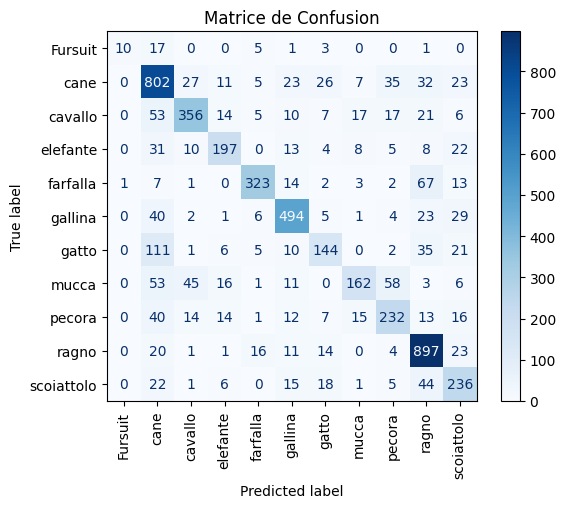

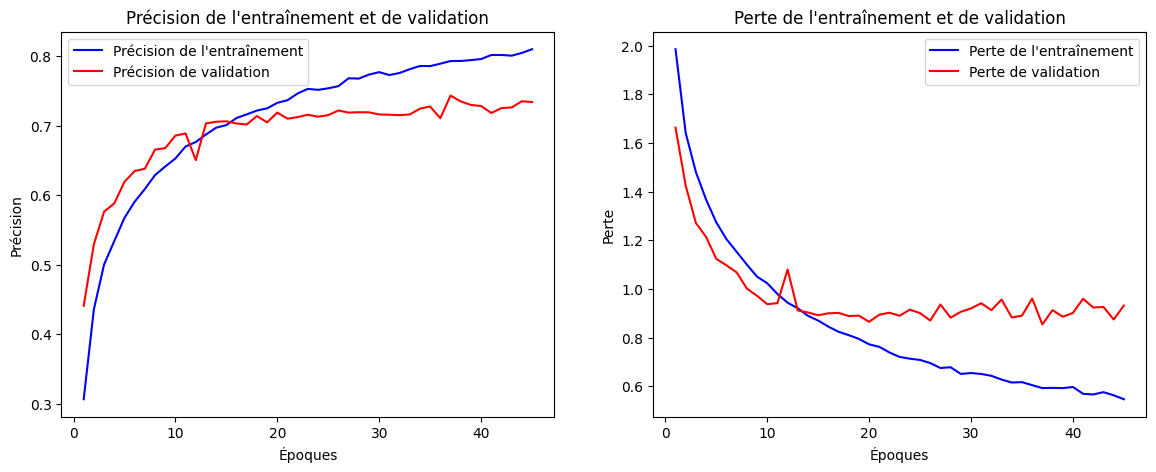

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=32,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

# Appliquer le prétraitement sur le dataset
dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle avec Dropout
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la première couche de convolution
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la deuxième couche de convolution
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),  # Dropout après la troisième couche de convolution
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model1.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model1.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=45
)

# Sauvegarder le modèle
model1.save('modele-B.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('modele-B.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Fonction pour obtenir les labels et prédictions
def get_labels_and_predictions(dataset, model):
    all_labels = []
    all_predictions = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_labels.append(labels.numpy())
        all_predictions.append(np.argmax(predictions, axis=-1))
    return np.concatenate(all_labels), np.concatenate(all_predictions)

# Évaluation du modèle
val_labels, val_predictions = get_labels_and_predictions(val_dataset, model1)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model C

| Hyperparamètre                   | Valeur                                  |
|---------------------------------|-----------------------------------------|
| **Taille de l'image**            | 64x64                                  |
| **Taille du batch**              | 32                                       |
| **Nombre d'époques**             | 50                                       |


Found 21107 images belonging to 11 classes.
Found 5272 images belonging to 11 classes.
Epoch 1/50


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


660/660 ━━━━━━━━━━━━━━━━━━━━ 435s 610ms/step - accuracy: 0.1014 - loss: 2.3820 - val_accuracy: 0.1713 - val_loss: 2.3043
Epoch 2/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 333s 503ms/step - accuracy: 0.1505 - loss: 2.2881 - val_accuracy: 0.1521 - val_loss: 2.2396
Epoch 3/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 375s 568ms/step - accuracy: 0.2004 - loss: 2.1223 - val_accuracy: 0.2898 - val_loss: 2.0222
Epoch 4/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 337s 510ms/step - accuracy: 0.2390 - loss: 2.0215 - val_accuracy: 0.2483 - val_loss: 2.0733
Epoch 5/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 548s 828ms/step - accuracy: 0.2616 - loss: 1.9609 - val_accuracy: 0.3200 - val_loss: 1.8934
Epoch 6/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 877s 1s/step - accuracy: 0.2941 - loss: 1.9091 - val_accuracy: 0.3594 - val_loss: 1.7952
Epoch 7/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 1026s 2s/step - accuracy: 0.3173 - loss: 1.8332 - val_accuracy: 0.3631 - val_loss: 1.7906
Epoch 8/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 864s 1s/step - accuracy: 0.3302 - loss: 1.7900 - val

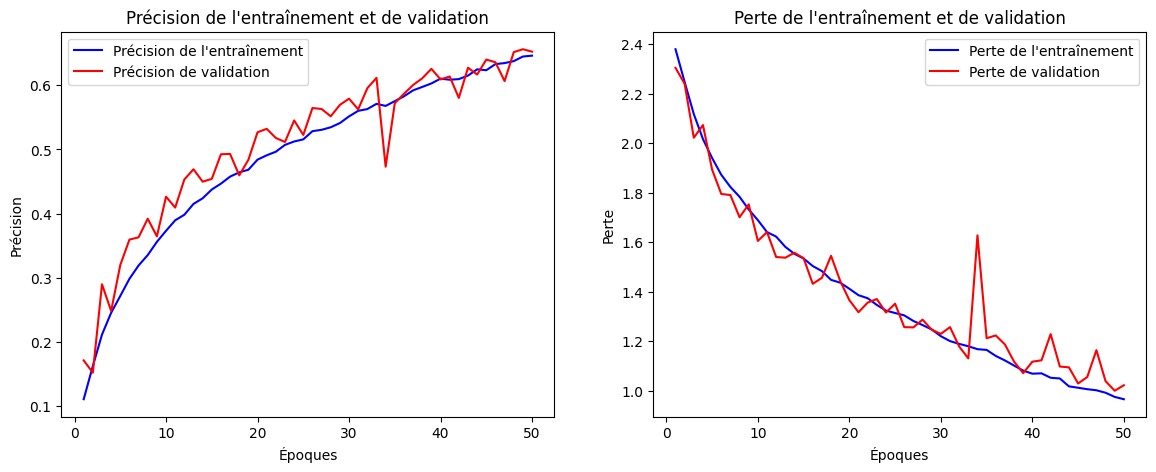

Expérimentation terminée et modèle sauvegardé.
165/165 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step


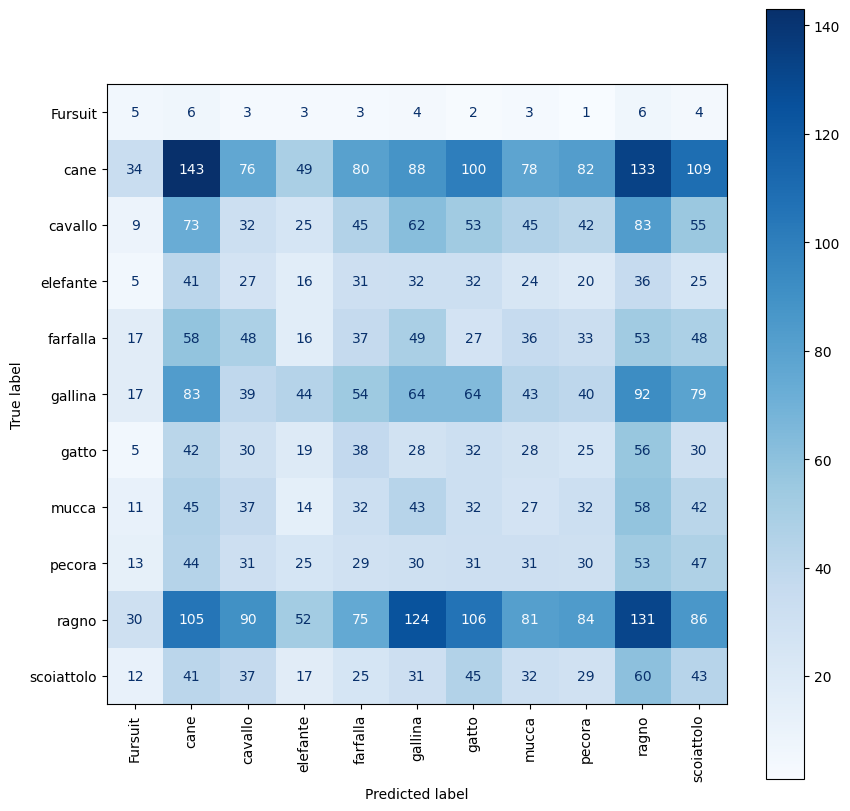

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.optimizers import Adam
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageEnhance
import h5py
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import os

def pretraiter_images(taille_image=(64, 64), taille_lot=32):
    def convertir_rgb_en_grayscale(image):
        image = img_to_array(image)
        image_gris = image.mean(axis=-1)
        image_gris = np.stack((image_gris,) * 3, axis=-1)
        return array_to_img(image_gris)

    def ameliorer_image(image):
        image = img_to_array(image)
        image = array_to_img(image)
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(np.random.uniform(0.8, 1.2))
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(np.random.uniform(0.8, 1.2))
        return img_to_array(image)

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=lambda image: ameliorer_image(image)
    )

    chemin_donnees = "TP2-images"

    generateur_entrainement = datagen.flow_from_directory(
        chemin_donnees,
        target_size=taille_image,
        batch_size=taille_lot,
        class_mode='categorical',
        subset='training'
    )

    generateur_validation = datagen.flow_from_directory(
        chemin_donnees,
        target_size=taille_image,
        batch_size=taille_lot,
        class_mode='categorical',
        subset='validation'
    )

    return generateur_entrainement, generateur_validation

def construire_modele(input_shape=(64, 64, 3), num_classes=11):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def entrainer_modele(model, generateur_entrainement, generateur_validation, epochs):
    start_time = time.time()

    # Calculer les poids des classes
    class_weights = compute_class_weight('balanced', classes=np.unique(generateur_entrainement.classes), y=generateur_entrainement.classes)
    class_weight_dict = dict(enumerate(class_weights))

    history = model.fit(
        generateur_entrainement,
        epochs=epochs,
        validation_data=generateur_validation,
        class_weight=class_weight_dict  # Ajustement des poids des classes
    )
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time

def afficher_graphiques(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
    plt.plot(epochs, val_acc, 'r', label='Précision de validation')
    plt.title('Précision de l\'entraînement et de validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte de validation')
    plt.title('Perte de l\'entraînement et de validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.show()

def afficher_matrice_confusion(modele, generateur_validation):
    y_true = generateur_validation.classes
    y_pred = np.argmax(modele.predict(generateur_validation, verbose=1), axis=-1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generateur_validation.class_indices.keys())
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=90)
    plt.show()

if __name__ == '__main__':
    generateur_entrainement, generateur_validation = pretraiter_images(taille_image=(64, 64), taille_lot=32)
    modele = construire_modele(input_shape=(64, 64, 3), num_classes=11)
    history, training_time = entrainer_modele(modele, generateur_entrainement, generateur_validation, epochs=50)
    print(f"Temps d'entraînement pour le Modèle: {training_time:.2f} secondes")

    afficher_graphiques(history)
    
    # Sauvegarder le modèle
    modele.save('model-C.h5')
    print("Expérimentation terminée et modèle sauvegardé.")
    
    # Ajouter les noms des classes dans le fichier HDF5
    with h5py.File('model-C.h5', 'a') as f:
        f.attrs['class_names'] = np.string_(list(generateur_entrainement.class_indices.keys()))

    # Afficher la matrice de confusion  
    afficher_matrice_confusion(modele, generateur_validation)


Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1627s 2s/step - accuracy: 0.2662 - loss: 2.0990 - val_accuracy: 0.4929 - val_loss: 1.4986
Epoch 2/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1393s 2s/step - accuracy: 0.5035 - loss: 1.4831 - val_accuracy: 0.6087 - val_loss: 1.1795
Epoch 3/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.5885 - loss: 1.2276 - val_accuracy: 0.6134 - val_loss: 1.1720
Epoch 4/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1091s 2s/step - accuracy: 0.6520 - loss: 1.0381 - val_accuracy: 0.6669 - val_loss: 0.9882
Epoch 5/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1042s 2s/step - accuracy: 0.7102 - loss: 0.8589 - val_accuracy: 0.6990 - val_loss: 0.9355
Epoch 6/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.7643 - loss: 0.7157 - val_accuracy: 0.7032 - val_loss: 0.9505
Epoch 7/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1437s 2s/step - accuracy: 0.8090 - loss: 0.5794 - val_accuracy: 0.7264 - val_loss: 0.8806
Epoch 8/20
660/660 ━━━━━━━━━━━━━━━━━━━━ 1265s 2s/step - accuracy: 0.8449 - loss: 0.4607 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

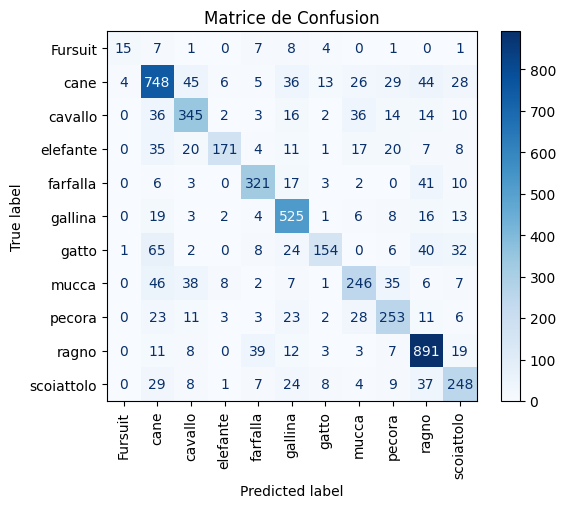

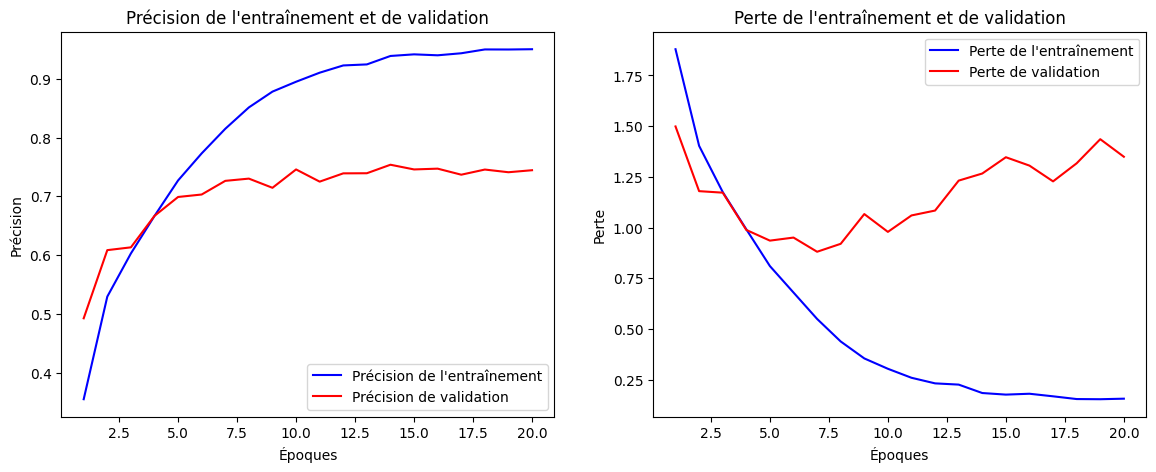

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0
    # Améliorer la luminosité et le contraste
    image = tf.image.adjust_brightness(image, delta=0.1)  # Ajuster la luminosité
    image = tf.image.adjust_contrast(image, contrast_factor=1.2)  # Ajuster le contraste
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(224, 224),
    batch_size=32,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

# Appliquer le prétraitement sur le dataset
dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20  # Augmenter le nombre d'époques pour permettre à l'architecture plus complexe de converger
)

# Sauvegarder le modèle
model.save('modele-C2.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('modele-C2.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Fonction pour obtenir les labels et prédictions
def get_labels_and_predictions(dataset, model):
    all_labels = []
    all_predictions = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_labels.append(labels.numpy())
        all_predictions.append(np.argmax(predictions, axis=-1))
    return np.concatenate(all_labels), np.concatenate(all_predictions)

# Évaluation du modèle
val_labels, val_predictions = get_labels_and_predictions(val_dataset, model)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model D

| Hyperparamètre                   | Valeur                                  |
|---------------------------------|-----------------------------------------|
| **Taille de l'image**            | 64x64                                  |
| **Taille du batch**              | 16                                       |
| **Nombre d'époques**             | 45                                       |

Found 21107 images belonging to 11 classes.
Found 5272 images belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Checkpoint chargé avec succès.
Epoch 1/45


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1320/1320 ━━━━━━━━━━━━━━━━━━━━ 701s 513ms/step - accuracy: 0.4278 - loss: 1.6877 - val_accuracy: 0.4759 - val_loss: 1.5314
Epoch 2/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 723s 545ms/step - accuracy: 0.4556 - loss: 1.6040 - val_accuracy: 0.4987 - val_loss: 1.4646
Epoch 3/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 944s 712ms/step - accuracy: 0.4806 - loss: 1.5406 - val_accuracy: 0.5152 - val_loss: 1.4269
Epoch 4/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 930s 702ms/step - accuracy: 0.4965 - loss: 1.4860 - val_accuracy: 0.5336 - val_loss: 1.3565
Epoch 5/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 691s 522ms/step - accuracy: 0.5052 - loss: 1.4499 - val_accuracy: 0.5563 - val_loss: 1.3346
Epoch 6/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 759s 573ms/step - accuracy: 0.5198 - loss: 1.4071 - val_accuracy: 0.5491 - val_loss: 1.3289
Epoch 7/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 916s 691ms/step - accuracy: 0.5348 - loss: 1.3770 - val_accuracy: 0.5518 - val_loss: 1.2953
Epoch 8/45
1320/1320 ━━━━━━━━━━━━━━━━━━━━ 904s 682ms/step - accuracy: 0.5

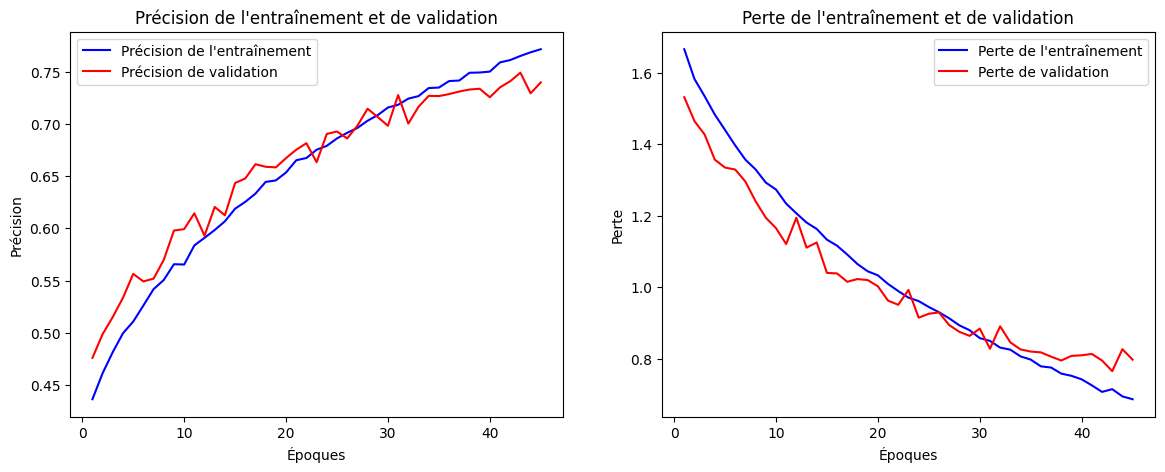

Expérimentation terminée et modèle sauvegardé.
330/330 ━━━━━━━━━━━━━━━━━━━━ 79s 237ms/step


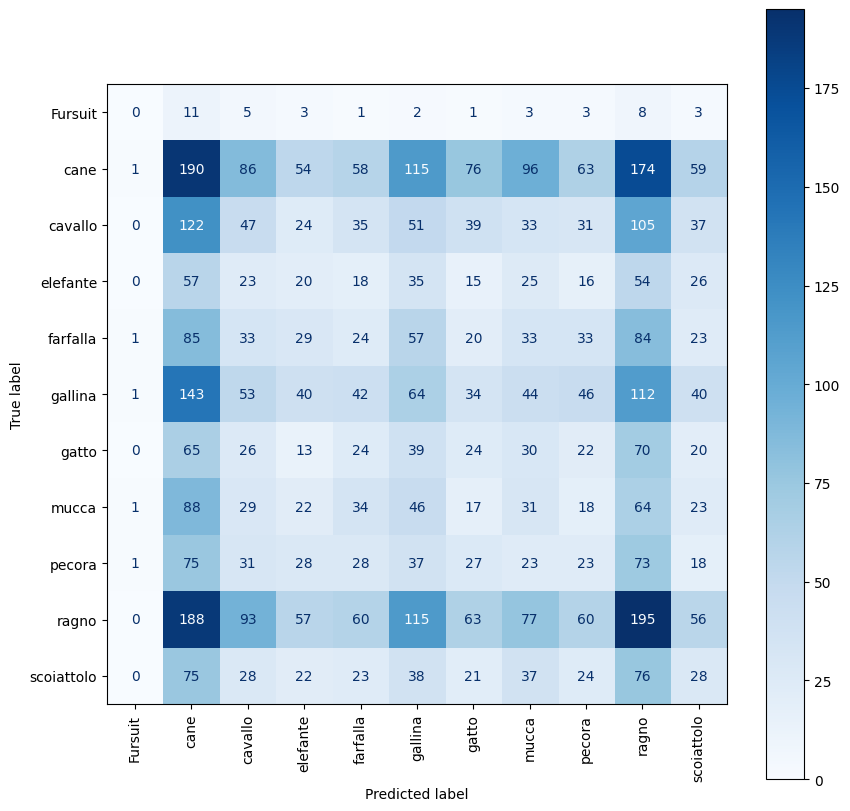

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageEnhance
import h5py
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def pretraiter_images(taille_image=(64, 64), taille_lot=16):
    def convertir_rgb_en_grayscale(image):
        image = img_to_array(image)
        image_gris = image.mean(axis=-1)
        image_gris = np.stack((image_gris,) * 3, axis=-1)
        return array_to_img(image_gris)

    def ameliorer_image(image):
        image = img_to_array(image)
        image = array_to_img(image)
        # Appliquer l'amélioration de la luminosité
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(np.random.uniform(0.8, 1.2))
        # Appliquer l'amélioration du contraste
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(np.random.uniform(0.8, 1.2))
        return img_to_array(image)

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        preprocessing_function=lambda image: ameliorer_image(image)
    )

    generateur_entrainement = datagen.flow_from_directory(
        "TP2-images",
        target_size=taille_image,
        batch_size=taille_lot,
        class_mode='categorical',
        subset='training'
    )

    generateur_validation = datagen.flow_from_directory(
        "TP2-images",
        target_size=taille_image,
        batch_size=taille_lot,
        class_mode='categorical',
        subset='validation'
    )

    return generateur_entrainement, generateur_validation

def construire_modele(input_shape=(64, 64, 3), num_classes=11):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def entrainer_modele(model, generateur_entrainement, generateur_validation, epochs, chemin_checkpoint):
    start_time = time.time()
    chemin_checkpoint = chemin_checkpoint.replace('.h5', '.weights.h5')
    checkpoint_callback = ModelCheckpoint(
        chemin_checkpoint,
        save_weights_only=True,
        save_best_only=False,
        save_freq='epoch'
    )
    try:
        model.load_weights(chemin_checkpoint)
        print("Checkpoint chargé avec succès.")
    except:
        print("Aucun checkpoint trouvé, démarrage à partir de zéro.")
    history = model.fit(
        generateur_entrainement,
        epochs=epochs,
        validation_data=generateur_validation,
        callbacks=[checkpoint_callback]
    )
    end_time = time.time()
    training_time = end_time - start_time
    return history, training_time

def afficher_graphiques(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
    plt.plot(epochs, val_acc, 'r', label='Précision de validation')
    plt.title('Précision de l\'entraînement et de validation')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
    plt.plot(epochs, val_loss, 'r', label='Perte de validation')
    plt.title('Perte de l\'entraînement et de validation')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()

    plt.show()

def afficher_matrice_confusion(modele, generateur_validation):
    y_true = generateur_validation.classes
    y_pred = np.argmax(modele.predict(generateur_validation, verbose=1), axis=-1)
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=generateur_validation.class_indices.keys())
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.xticks(rotation=90)
    plt.show()

if __name__ == '__main__':
    generateur_entrainement, generateur_validation = pretraiter_images(taille_image=(64, 64), taille_lot=16)
    modele = construire_modele(input_shape=(64, 64, 3), num_classes=11)
    history, training_time = entrainer_modele(modele, generateur_entrainement, generateur_validation, epochs=45, chemin_checkpoint='modele_checkpoint.h5')
    print(f"Temps d'entraînement pour le Modèle: {training_time:.2f} secondes")

    afficher_graphiques(history)
    
    # Sauvegarder le modèle
    modele.save('modele-D.h5')
    print("Expérimentation terminée et modèle sauvegardé.")
    
    # Ajouter les noms des classes dans le fichier HDF5
    with h5py.File('modele-D.h5', 'a') as f:
        f.attrs['class_names'] = np.string_(list(generateur_entrainement.class_indices.keys()))

    # Afficher la matrice de confusion
    afficher_matrice_confusion(modele, generateur_validation)


Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 71s 52ms/step - accuracy: 0.2228 - loss: 2.1971 - val_accuracy: 0.4176 - val_loss: 1.7209
Epoch 2/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - accuracy: 0.4173 - loss: 1.6958 - val_accuracy: 0.5357 - val_loss: 1.3592
Epoch 3/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.5213 - loss: 1.4286 - val_accuracy: 0.5992 - val_loss: 1.2020
Epoch 4/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - accuracy: 0.5812 - loss: 1.2679 - val_accuracy: 0.6400 - val_loss: 1.1119
Epoch 5/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.6117 - loss: 1.1512 - val_accuracy: 0.6476 - val_loss: 1.0671
Epoch 6/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.6482 - loss: 1.0545 - val_accuracy: 0.6629 - val_loss: 1.0284
Epoch 7/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 66s 50ms/step - accuracy: 0.6732 - loss: 0.9616 - val_accuracy: 0.6718 - val_loss: 1.0130
Epoch 8/45
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 67s 51ms/step - accuracy: 0.6986 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

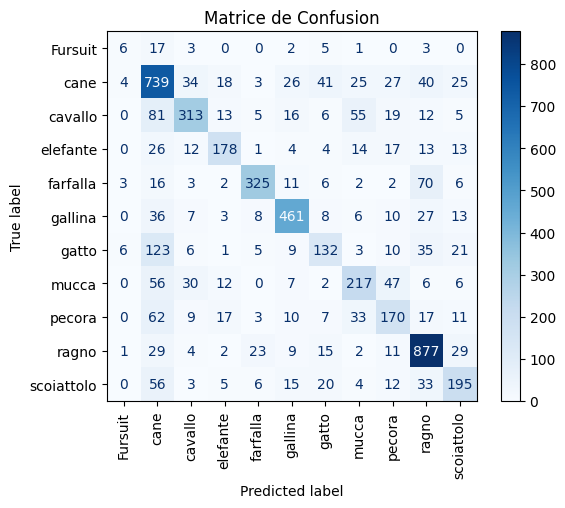

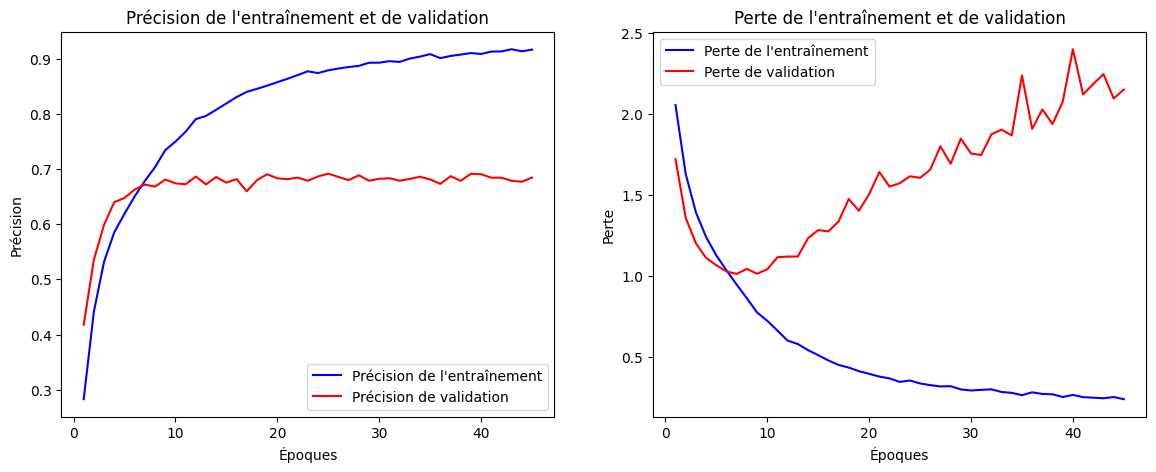

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [64, 64])
    image = image / 255.0
    # Améliorer la luminosité et le contraste
    image = tf.image.adjust_brightness(image, delta=0.1)  # Ajuster la luminosité
    image = tf.image.adjust_contrast(image, contrast_factor=1.2)  # Ajuster le contraste
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(64, 64),
    batch_size=16,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

# Appliquer le prétraitement sur le dataset
dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=45  # Augmenter le nombre d'époques pour permettre à l'architecture plus complexe de converger
)

# Sauvegarder le modèle
model.save('modele-D5.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('modele-D5.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Fonction pour obtenir les labels et prédictions
def get_labels_and_predictions(dataset, model):
    all_labels = []
    all_predictions = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_labels.append(labels.numpy())
        all_predictions.append(np.argmax(predictions, axis=-1))
    return np.concatenate(all_labels), np.concatenate(all_predictions)

# Évaluation du modèle
val_labels, val_predictions = get_labels_and_predictions(val_dataset, model)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()


### Model E

| Hyperparamètre                   | Valeur                                  |
|---------------------------------|-----------------------------------------|
| **Taille de l'image**            | 128x128                                  |
| **Taille du batch**              | 32                                       |
| **Nombre d'époques**             | 10                                       |

Found 26379 files belonging to 11 classes.


C:\Users\jprue\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 536s 805ms/step - accuracy: 0.2537 - loss: 2.1330 - val_accuracy: 0.4959 - val_loss: 1.5334
Epoch 2/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 4868s 7s/step - accuracy: 0.4690 - loss: 1.5640 - val_accuracy: 0.6170 - val_loss: 1.1680
Epoch 3/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.5816 - loss: 1.2527 - val_accuracy: 0.6262 - val_loss: 1.1293
Epoch 4/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 1132s 2s/step - accuracy: 0.6412 - loss: 1.0752 - val_accuracy: 0.6760 - val_loss: 0.9894
Epoch 5/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 1136s 2s/step - accuracy: 0.6826 - loss: 0.9300 - val_accuracy: 0.7036 - val_loss: 0.9236
Epoch 6/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 868s 1s/step - accuracy: 0.7359 - loss: 0.7842 - val_accuracy: 0.7264 - val_loss: 0.8938
Epoch 7/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 1015s 2s/step - accuracy: 0.7673 - loss: 0.6887 - val_accuracy: 0.7271 - val_loss: 0.9035
Epoch 8/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 1356s 2s/step - accuracy: 0.8033 - loss: 0.5776 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 871ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 631ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 767ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 932ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

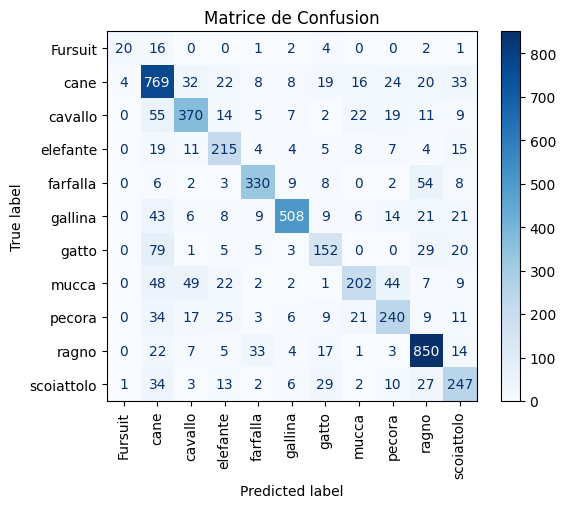

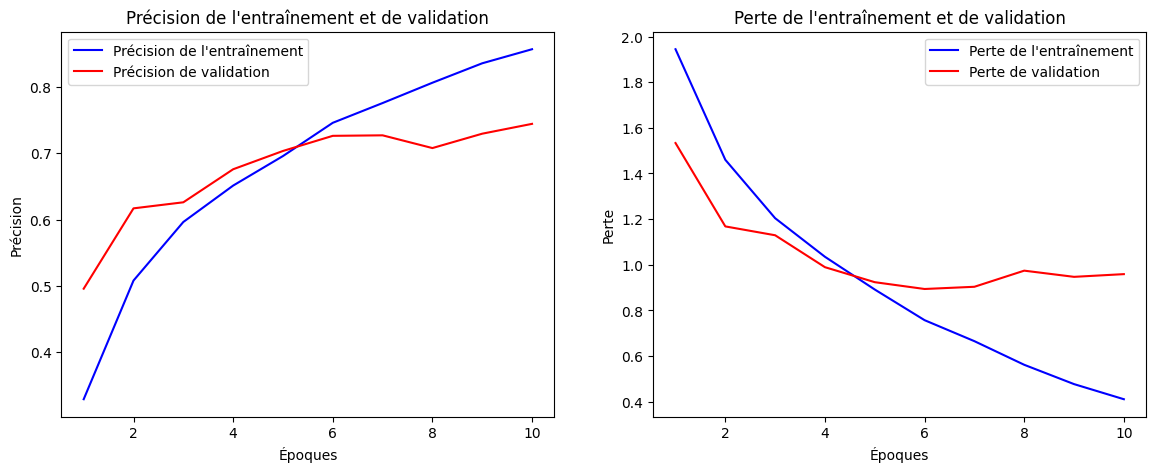

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import h5py

# Fonction de prétraitement des images
def preprocess_image(image, label):
    image = tf.image.resize(image, [128, 128])
    image = image / 255.0
    # Améliorer la luminosité et le contraste
    image = tf.image.adjust_brightness(image, delta=0.1)  # Ajuster la luminosité
    image = tf.image.adjust_contrast(image, contrast_factor=1.2)  # Ajuster le contraste
    return image, label

# Chargement du dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'TP2-images',
    image_size=(128, 128),
    batch_size=32,
    label_mode='int'
)

# Obtenir les noms des classes
class_names = dataset.class_names

# Appliquer le prétraitement sur le dataset
dataset = dataset.map(preprocess_image)

# Nombre de classes (ajustez en fonction du nombre réel de classes)
NUM_CLASSES = len(class_names)

# Révision de l'architecture du modèle
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Dropout avant la couche dense finale
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Couche de sortie avec activation softmax
])

# Compilation du modèle
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fonction pour diviser le dataset
def split_dataset(dataset, split_ratio=0.8):
    dataset_size = len(list(dataset))
    split_index = int(dataset_size * split_ratio)
    train_dataset = dataset.take(split_index)
    val_dataset = dataset.skip(split_index)
    return train_dataset, val_dataset

# Diviser les données
train_dataset, val_dataset = split_dataset(dataset)

# Entraîner le modèle
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

# Sauvegarder le modèle
model.save('modele-E.h5')

# Ajouter les noms des classes dans le fichier HDF5
with h5py.File('modele-E.h5', 'a') as f:
    f.attrs['class_names'] = np.string_(class_names)

# Fonction pour obtenir les labels et prédictions
def get_labels_and_predictions(dataset, model):
    all_labels = []
    all_predictions = []
    for images, labels in dataset:
        predictions = model.predict(images)
        all_labels.append(labels.numpy())
        all_predictions.append(np.argmax(predictions, axis=-1))
    return np.concatenate(all_labels), np.concatenate(all_predictions)

# Évaluation du modèle
val_labels, val_predictions = get_labels_and_predictions(val_dataset, model)

# Matrice de confusion
cm = confusion_matrix(val_labels, val_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Matrice de Confusion')
plt.show()

# Graphique de précision et perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Précision de l\'entraînement')
plt.plot(epochs, val_acc, 'r', label='Précision de validation')
plt.title('Précision de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Perte de l\'entraînement')
plt.plot(epochs, val_loss, 'r', label='Perte de validation')
plt.title('Perte de l\'entraînement et de validation')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.show()
